<a href="https://colab.research.google.com/github/anaisaoviedo-upb/Ensambles/blob/main/Ensamble_para_regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensamble de Regresores
1. Preparación de datos
2. División de datos
3. Predictores individuales
4. Bagging
5. Random Forest
6. Boosting
7. Votación "hard"
8. Votación "soft"
9. Stacking
10. Guardamos el mejor modelo


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 1. Preparación de datos

In [ ]:
data = pd.read_excel("Emisiones CO2.xlsx",sheet_name=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Tipo_vehiculo                  3985 non-null   object 
 1   Tamano_motor                   3985 non-null   float64
 2   Cilindros                      3985 non-null   int64  
 3   Consumo_combustible_ciudad     3985 non-null   float64
 4   Consumo_combustible_carretera  3985 non-null   float64
 5   CO2_Emision                    3985 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 186.9+ KB


In [ ]:
#Correccion de tipo de datos


<Axes: xlabel='Tipo_vehiculo'>

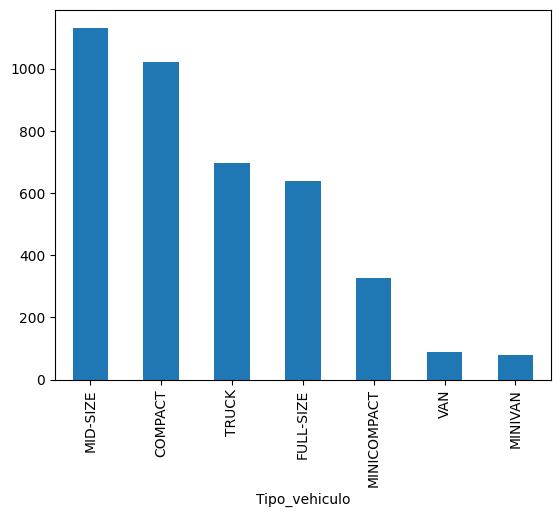

In [ ]:
data['Tipo_vehiculo'].value_counts().plot(kind='bar')

<Axes: >

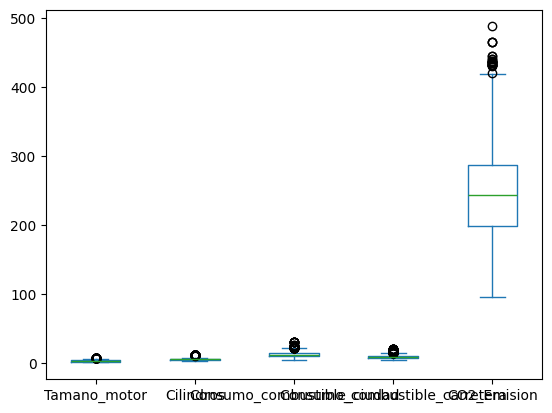

In [ ]:
data.plot(kind='box')

In [ ]:
#Normalizacion las variables numéricas (las dummies no se normalizan)
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
variables_numericas=['Tamano_motor','Cilindros','Consumo_combustible_ciudad','Consumo_combustible_carretera']
min_max_scaler.fit(data[variables_numericas]) #Ajuste de los parametros: max - min
data[variables_numericas]= min_max_scaler.transform(data[variables_numericas]) #70%
data.head()

,Tipo_vehiculo,Tamano_motor,Cilindros,Consumo_combustible_ciudad,Consumo_combustible_carretera,CO2_Emision
0,COMPACT,0.172414,0.111111,0.215909,0.162651,196
1,COMPACT,0.241379,0.111111,0.265152,0.222892,221
2,COMPACT,0.086207,0.111111,0.068182,0.108434,136
3,MID-SIZE,0.431034,0.333333,0.291667,0.222892,230
4,MID-SIZE,0.431034,0.333333,0.287879,0.240964,232


In [ ]:
#Dummies para las variables predictoras
data = pd.get_dummies(data, columns=['Tipo_vehiculo'], drop_first=False)
data.head()

,Tamano_motor,Cilindros,Consumo_combustible_ciudad,Consumo_combustible_carretera,CO2_Emision,Tipo_vehiculo_COMPACT,Tipo_vehiculo_FULL-SIZE,Tipo_vehiculo_MID-SIZE,Tipo_vehiculo_MINICOMPACT,Tipo_vehiculo_MINIVAN,Tipo_vehiculo_TRUCK,Tipo_vehiculo_VAN
0,0.172414,0.111111,0.215909,0.162651,196,True,False,False,False,False,False,False
1,0.241379,0.111111,0.265152,0.222892,221,True,False,False,False,False,False,False
2,0.086207,0.111111,0.068182,0.108434,136,True,False,False,False,False,False,False
3,0.431034,0.333333,0.291667,0.222892,230,False,False,True,False,False,False,False
4,0.431034,0.333333,0.287879,0.240964,232,False,False,True,False,False,False,False


# **2.División 70-30**

<Axes: ylabel='Frequency'>

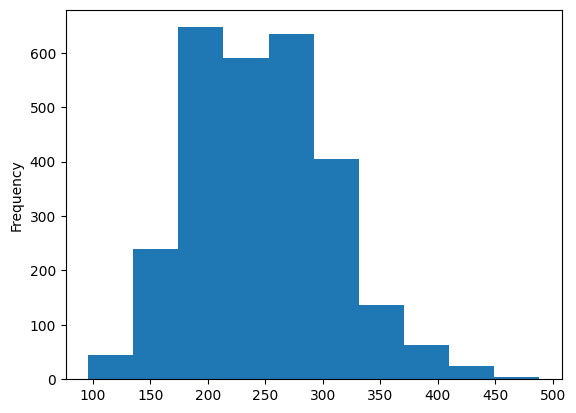

In [ ]:
#División 70-30
from sklearn.model_selection import train_test_split
X = data.drop("CO2_Emision", axis = 1)
Y = data['CO2_Emision']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3) #En regresion no es muestreo estratificado
Y_train.plot(kind='hist')

# **3. Predictores individuales (base learners)**

In [ ]:
#Dataframe para comparar los resultados
medidas= pd.DataFrame(index=['mse','rmse','mae','mape','max'])

In [ ]:
#Arbol de clasificación
from sklearn.tree import DecisionTreeRegressor
model_dt = DecisionTreeRegressor(criterion='squared_error', min_samples_leaf=20, max_depth=4)
model_dt.fit(X_train, Y_train) # 70%

#Evaluación
from sklearn import metrics
Y_pred = model_dt.predict(X_test)#  30%


mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Arbol']=[mse, rmse, mae, mape,max]
medidas


,Arbol
mse,285.436367
rmse,16.894862
mae,11.028216
mape,0.045439
max,89.704348


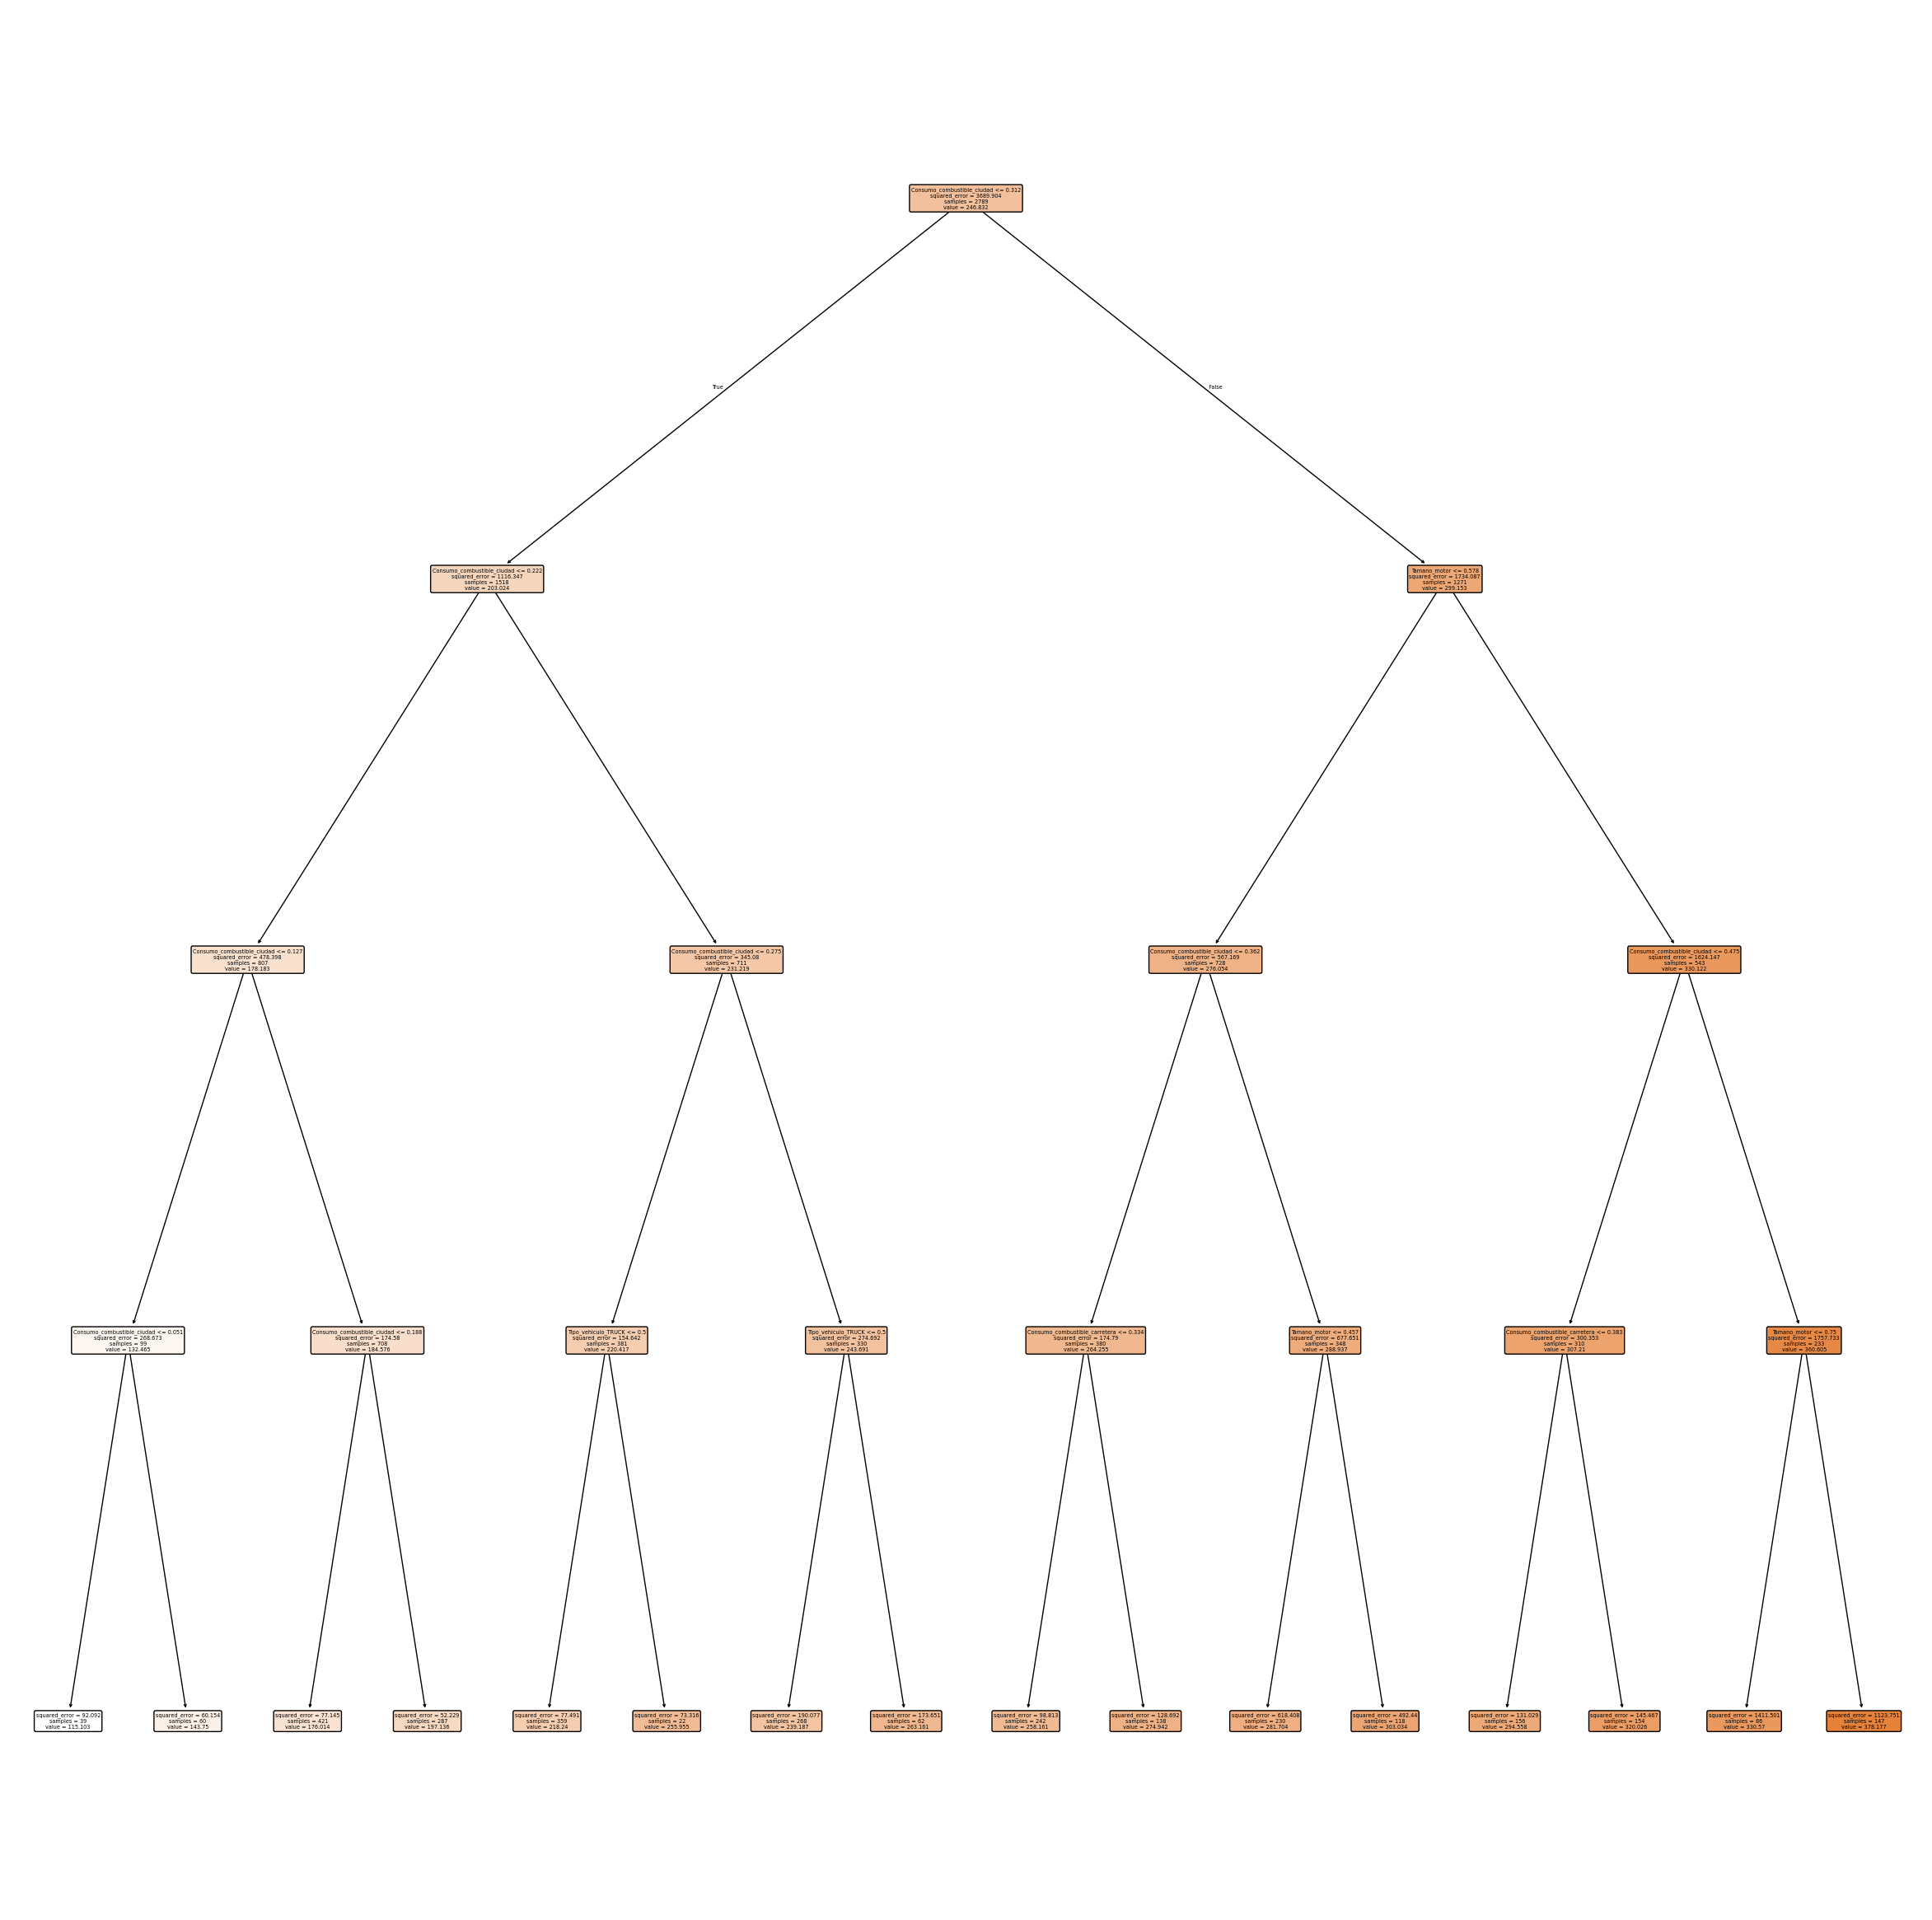

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30,30))
plot_tree(model_dt, feature_names=X_train.columns.values,  rounded=True, filled=True)
plt.show()

In [ ]:
model_dt.feature_names_in_

array(['Tamano_motor', 'Cilindros', 'Consumo_combustible_ciudad',
       'Consumo_combustible_carretera', 'Tipo_vehiculo_COMPACT',
       'Tipo_vehiculo_FULL-SIZE', 'Tipo_vehiculo_MID-SIZE',
       'Tipo_vehiculo_MINICOMPACT', 'Tipo_vehiculo_MINIVAN',
       'Tipo_vehiculo_TRUCK', 'Tipo_vehiculo_VAN'], dtype=object)

In [ ]:
model_dt.feature_importances_


array([0.11151838, 0.        , 0.87454344, 0.00783537, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00610281,
       0.        ])

In [ ]:
#Método Perezoso
from sklearn.neighbors import KNeighborsRegressor
model_knn = KNeighborsRegressor(n_neighbors=1, metric='euclidean') #minkowski
model_knn.fit(X_train, Y_train)

#Evaluación
from sklearn import metrics
Y_pred = model_knn.predict(X_test)
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Knn']=[mse, rmse, mae, mape,max]
medidas




,Arbol,Knn
mse,285.436367,41.059365
rmse,16.894862,6.407758
mae,11.028216,2.788462
mape,0.045439,0.012201
max,89.704348,74.000000


In [ ]:
#Red neuronal
from sklearn.neural_network import MLPRegressor
model_rn = MLPRegressor(activation="logistic",hidden_layer_sizes=(10), learning_rate='adaptive',
                     learning_rate_init=0.2, momentum= 0.3, max_iter=500, verbose=False)
model_rn.fit(X_train, Y_train)

#Evaluación
Y_pred = model_rn.predict(X_test)
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['NN']=[mse, rmse, mae, mape,max]
medidas




,Arbol,Knn,NN
mse,285.436367,41.059365,139.457351
rmse,16.894862,6.407758,11.809206
mae,11.028216,2.788462,6.280981
mape,0.045439,0.012201,0.026021
max,89.704348,74.000000,95.855814


# 4. Bagging

In [ ]:
#Bagging: Knn
from sklearn.ensemble import BaggingRegressor
modelo_base=KNeighborsRegressor(n_neighbors=1, metric='euclidean')
model_bag = BaggingRegressor(modelo_base, n_estimators=10, max_samples=0.6)
model_bag.fit(X_train, Y_train)#70%

#Evaluación
Y_pred = model_bag.predict(X_test) #30%
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Bagging']=[mse, rmse, mae, mape,max]
medidas


,Arbol,Knn,NN,Bagging
mse,285.436367,41.059365,139.457351,46.356380
rmse,16.894862,6.407758,11.809206,6.808552
mae,11.028216,2.788462,6.280981,3.426839
mape,0.045439,0.012201,0.026021,0.014692
max,89.704348,74.000000,95.855814,69.200000


# 5. Random Forest (bagging)

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
model_rf= RandomForestRegressor(n_estimators=100,  max_samples=0.7, criterion='squared_error',
                              max_depth=None, min_samples_leaf=2)
model_rf.fit(X_train, Y_train) #70%


#Evaluación
Y_pred = model_rf.predict(X_test) #30%
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Random_Forest']=[mse, rmse, mae, mape,max]
medidas


,Arbol,Knn,NN,Bagging,Random_Forest
mse,285.436367,41.059365,139.457351,46.356380,57.515438
rmse,16.894862,6.407758,11.809206,6.808552,7.583893
mae,11.028216,2.788462,6.280981,3.426839,3.299009
mape,0.045439,0.012201,0.026021,0.014692,0.014356
max,89.704348,74.000000,95.855814,69.200000,91.387131


In [ ]:
# Se imprimen la importancia de las características
print('Importancia de las características')
for i, j in sorted(zip(X_train.columns, model_rf.feature_importances_)):
    print(i, j)

Importancia de las características
Cilindros 0.0012892712112814613
Consumo_combustible_carretera 0.2961370945927504
Consumo_combustible_ciudad 0.5681156840273831
Tamano_motor 0.11695079540346216
Tipo_vehiculo_COMPACT 0.0002884674918008129
Tipo_vehiculo_FULL-SIZE 0.0001785817039865785
Tipo_vehiculo_MID-SIZE 0.00020693872012537764
Tipo_vehiculo_MINICOMPACT 2.6093124340543208e-05
Tipo_vehiculo_MINIVAN 1.8310774789974836e-05
Tipo_vehiculo_TRUCK 0.008542500623531698
Tipo_vehiculo_VAN 0.008246262326548022


# 6. Boosting

In [ ]:
#Boosting
from sklearn.ensemble import AdaBoostRegressor
modelo_base=DecisionTreeRegressor(criterion='squared_error', max_depth=None, min_samples_leaf=2)
model_boos = AdaBoostRegressor(modelo_base, n_estimators=50)
model_boos.fit(X_train, Y_train)#70%

#Evaluación
Y_pred = model_boos.predict(X_test)#30%
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Boosting']=[mse, rmse, mae, mape,max]
medidas

,Arbol,Knn,NN,Bagging,Random_Forest,Boosting
mse,285.436367,41.059365,139.457351,46.356380,57.515438,56.098857
rmse,16.894862,6.407758,11.809206,6.808552,7.583893,7.489917
mae,11.028216,2.788462,6.280981,3.426839,3.299009,2.813080
mape,0.045439,0.012201,0.026021,0.014692,0.014356,0.012631
max,89.704348,74.000000,95.855814,69.200000,91.387131,91.000000


Librerías y Métodos nuevos de tipo boosting
* GradientBoostingRegressor (sklearn)
* Librería XGBoost
* Librería Catboost (no se crean dummies, trabaja con variables categóricas)

# 7. Votación "hard"

In [ ]:
#Votación hard
from sklearn.ensemble import VotingRegressor

regresores= [('dt', model_dt), ('knn', model_knn), ('net', model_rn)]

model_vot_hard = VotingRegressor(estimators=regresores, weights=None)
model_vot_hard.fit(X_train,Y_train) #70%

#Evaluación
Y_pred = model_vot_hard.predict(X_test)#30%
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Votacion_hard']=[mse, rmse, mae, mape,max]
medidas


,Arbol,Knn,NN,Bagging,Random_Forest,Boosting,Votacion_hard
mse,285.436367,41.059365,139.457351,46.356380,57.515438,56.098857,93.183051
rmse,16.894862,6.407758,11.809206,6.808552,7.583893,7.489917,9.653137
mae,11.028216,2.788462,6.280981,3.426839,3.299009,2.813080,5.579798
mape,0.045439,0.012201,0.026021,0.014692,0.014356,0.012631,0.023250
max,89.704348,74.000000,95.855814,69.200000,91.387131,91.000000,72.796223


# 8. Votación "soft"

In [ ]:
#Votación soft

from sklearn.ensemble import VotingRegressor

regresores= [('dt', model_dt), ('knn', model_knn), ('net', model_rn)]
model_vot_soft = VotingRegressor(estimators=regresores, weights=[0.2, 0.4, 0.3])
model_vot_soft.fit(X_train,Y_train) #70%

#Evaluación
Y_pred = model_vot_soft.predict(X_test) #30%
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Votacion_soft']=[mse, rmse, mae, mape,max]
medidas



,Arbol,Knn,NN,Bagging,Random_Forest,Boosting,Votacion_hard,Votacion_soft
mse,285.436367,41.059365,139.457351,46.356380,57.515438,56.098857,93.183051,72.858489
rmse,16.894862,6.407758,11.809206,6.808552,7.583893,7.489917,9.653137,8.535718
mae,11.028216,2.788462,6.280981,3.426839,3.299009,2.813080,5.579798,4.738133
mape,0.045439,0.012201,0.026021,0.014692,0.014356,0.012631,0.023250,0.020013
max,89.704348,74.000000,95.855814,69.200000,91.387131,91.000000,72.796223,73.365604


# 9. Stacking

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

regresores= [('dt', model_dt), ('knn', model_knn), ('net', model_rn)]

metodo_ensamblador= LinearRegression()

#metodo_ensamblador = SVR(kernel='linear', probability=True) #'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'

model_stack= StackingRegressor(estimators=regresores, final_estimator=metodo_ensamblador)
model_stack.fit(X_train,Y_train)#70%

#Evaluación
Y_pred = model_stack.predict(X_test) #30%
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Stacking']=[mse, rmse, mae, mape,max]
medidas


,Arbol,Knn,NN,Bagging,Random_Forest,Boosting,Votacion_hard,Votacion_soft,Stacking
mse,285.436367,41.059365,139.457351,46.356380,57.515438,56.098857,93.183051,72.858489,39.595734
rmse,16.894862,6.407758,11.809206,6.808552,7.583893,7.489917,9.653137,8.535718,6.292514
mae,11.028216,2.788462,6.280981,3.426839,3.299009,2.813080,5.579798,4.738133,3.095245
mape,0.045439,0.012201,0.026021,0.014692,0.014356,0.012631,0.023250,0.020013,0.013234
max,89.704348,74.000000,95.855814,69.200000,91.387131,91.000000,72.796223,73.365604,72.639599


# **10. Guardamos el mejor modelo**

In [ ]:
import pickle
filename = 'modelo-ensamble-reg.pkl'
variables=X.columns._values
pickle.dump([model_boos,variables, min_max_scaler], open(filename, 'wb'))

